<a href="https://colab.research.google.com/github/Janakisrija/64061/blob/main/Assignment2_AML_Convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Assignment 2 - Convolution networks(Convnets) to image data.


### In this assignment, you will examine the relationship between training samples and the choice of training your model from scratch, versus using a pretrained convnet.

###The training archive contains 25,000 images of dogs and cats. This dataset is a standard computer vision dataset that involves classifying photos as either containing a dog or a cat. 

### Downloading the data

 Uploading the json file from kaggle to access the data from dogs-vs-cats dataset.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"janakisrijamaddukuri","key":"6d56a38e359f620ff527dadb0aaf6415"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 97% 790M/812M [00:04<00:00, 215MB/s]
100% 812M/812M [00:04<00:00, 171MB/s]


In [ ]:
!unzip -qq dogs-vs-cats

In [ ]:
!unzip -qq test1.zip

In [ ]:
!unzip -qq train.zip

In [ ]:
#shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
#shutil.rmtree("./test1", ignore_errors=True)
#shutil.rmtree("./train", ignore_errors=True)


## Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?


### Here the training sample is of 1000 images with test and validation samples of 500 images.

#### Test Accuracy - 70.6%

#### Training Accuraccy - 98.25%

#### Validation Accuracy - 74.3%

**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


# Training has 1000 samples, test has 500 samples and validation has 500 samples.

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

##Data Preprocessing
#### An integral step in machine learning as the quality of the data and the useful information that can be derived from it directly affects the ability of our model to learn.

####1.Read the pictures
####2.Convert JPEG content into RGB grid of pixels
####3. Convert RGB grid of pixels into floating point tensors
####4. Resize them
####5. Make them into batches

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Create a dataset instance from NumPy array of random numbers of 1000 samples and each sample of vector size 16

In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


Batching the data into batches of size 32

In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


##Building the model

**Instantiating a small convnet for dogs vs. cats classification**


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

#### After compiling the model, we train it on the training dataset, validating the results at the end of each epoch with the validation dataset. I'm making use of GPU to reduce the amount of time each epoch takes in execution.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Fitting the model using a `Dataset`**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 19s 124ms/step - loss: 0.6959 - accuracy: 0.5060 - val_loss: 0.6894 - val_accuracy: 0.5270
Epoch 2/30
63/63 [==============================] - 8s 128ms/step - loss: 0.6911 - accuracy: 0.5220 - val_loss: 0.6919 - val_accuracy: 0.5050
Epoch 3/30
63/63 [==============================] - 8s 111ms/step - loss: 0.6907 - accuracy: 0.5160 - val_loss: 0.6834 - val_accuracy: 0.5530
Epoch 4/30
63/63 [==============================] - 7s 110ms/step - loss: 0.6834 - accuracy: 0.5395 - val_loss: 0.6413 - val_accuracy: 0.6270
Epoch 5/30
63/63 [==============================] - 7s 110ms/step - loss: 0.6665 - accuracy: 0.5865 - val_loss: 0.6169 - val_accuracy: 0.6470
Epoch 6/30
63/63 [==============================] - 7s 110ms/step - loss: 0.6300 - accuracy: 0.6615 - val_loss: 0.5932 - val_accuracy: 0.6730
Epoch 7/30
63/63 [==============================] - 7s 109ms/step - loss: 0.6150 - accuracy: 0.6670 - val_loss: 0.6244 - val_accuracy: 0.6570
Epoch

**Displaying curves of loss and accuracy during training**

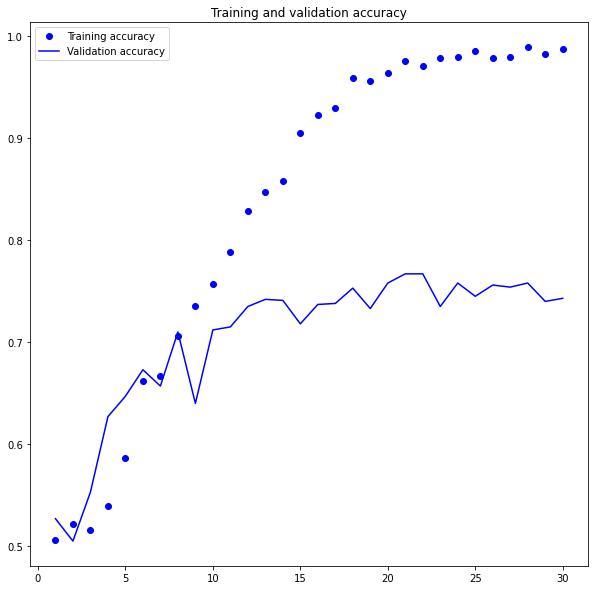

<Figure size 432x288 with 0 Axes>

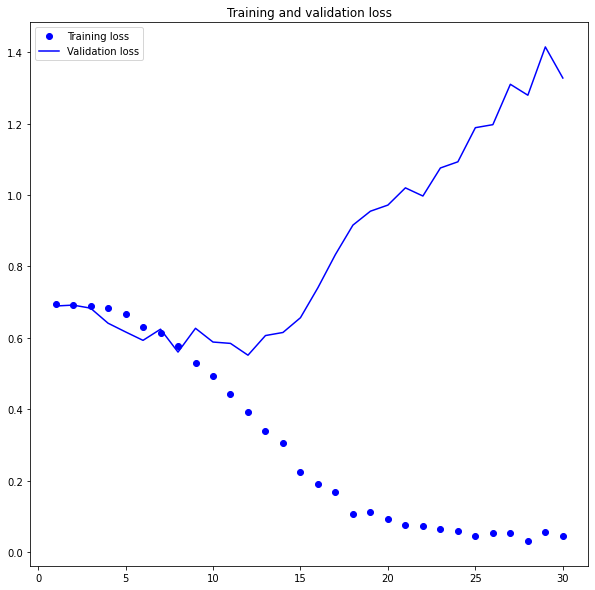

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We can conclude the following from the above plots:

*  The Training accuracy did not reach 100% because of the large dropout rate.
*   The network starts overfitting at epoch 8, even with such a large dropout rate.

*   The validation accuracy plateaus around 74%, which is not too bad.

We cannot increase dropout further, so we would need more data to do a better job. 








**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 44ms/step - loss: 0.5892 - accuracy: 0.7060
Test accuracy: 0.706


From the above result we can conclude that the test accuracy is about 70.6% when the Training accuracy is about 98.75%.

## Q2.  Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

#### Test Accuracy - 80.9%

#### Training Accuraccy - 84.9%

#### Validation Accuracy - 82.2%


**Define a data augmentation stage to add to an image model**

In [ ]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

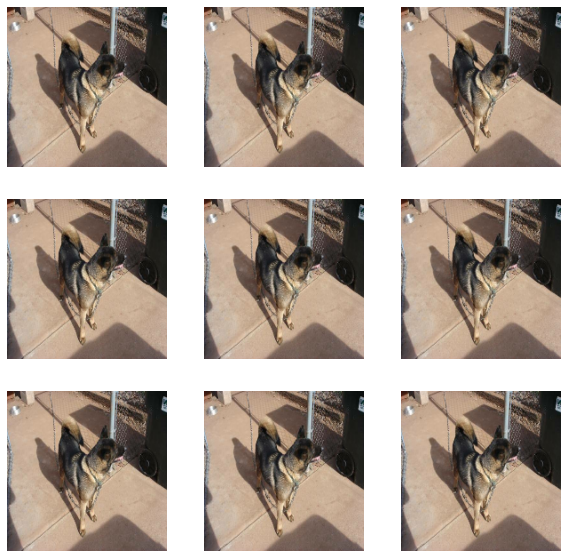

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 117ms/step - loss: 0.6911 - accuracy: 0.5310 - val_loss: 0.6844 - val_accuracy: 0.5040
Epoch 2/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6839 - accuracy: 0.5630 - val_loss: 0.6729 - val_accuracy: 0.5430
Epoch 3/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6690 - accuracy: 0.5905 - val_loss: 0.6308 - val_accuracy: 0.6440
Epoch 4/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6471 - accuracy: 0.6245 - val_loss: 0.6191 - val_accuracy: 0.6460
Epoch 5/50
63/63 [==============================] - 8s 115ms/step - loss: 0.6395 - accuracy: 0.6360 - val_loss: 0.6486 - val_accuracy: 0.6370
Epoch 6/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6284 - accuracy: 0.6535 - val_loss: 0.6139 - val_accuracy: 0.6640
Epoch 7/50
63/63 [==============================] - 8s 116ms/step - loss: 0.6138 - accuracy: 0.6650 - val_loss: 0.5979 - val_accuracy: 0.6680
Epoch 

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 45ms/step - loss: 0.4782 - accuracy: 0.8090
Test accuracy: 0.809


## Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.




#### Test Accuracy - 75.9%

#### Training Accuraccy - 81.05%

#### Validation Accuracy - 79.50%

### In this step 3, I used 2000 training samples with validation and test sets with 500 samples. I noticed that the test accuracy is better when the training sample is 1500 images than 1000 and 2000 training samples. 
### Training accuracy is better when there are 1000 training samples.

### Increasing the training sample to 2000, keeping the Validation and test sets the same as before which is 500 samples.

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

**Defining a new convnet with increased training samples,image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 117ms/step - loss: 0.6951 - accuracy: 0.4980 - val_loss: 0.6926 - val_accuracy: 0.5740
Epoch 2/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6914 - accuracy: 0.5270 - val_loss: 0.6929 - val_accuracy: 0.5550
Epoch 3/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 7s 113ms/step - loss: 0.6935 - accuracy: 0.4885 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 5/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6934 - accuracy: 0.4985 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 6/50
63/63 [==============================] - 8s 115ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6900 - val_accuracy: 0.5140
Epoch 7/50
63/63 [==============================] - 7s 113ms/step - loss: 0.6884 - accuracy: 0.5430 - val_loss: 0.6987 - val_accuracy: 0.5030
Epoch 

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 45ms/step - loss: 0.4798 - accuracy: 0.7590
Test accuracy: 0.759


## Summary for Q1, Q2 and Q3

---

####  In the first question a small training set of 1000 samples is used and got us training accuracy of 98.25%.

#### The data augmentation is done to reduce the overfitting. 

#### The following are the best approaches to avoid overfitting, as determined by manipulating the training sample and using other optimization techniques.
####1. **Increasing the training sample** - It is not always possible to increase the training sample. Data Augmentation is one technique to make the most of the fewer training data.
#### 2. **Reducing the network's capacity** - Overfitting is significantly reduced when the model's size is reduced, i.e. the number of learnable parameters in the model, which is effectively the number of layers and the number of units in layers.
#### 3. **Adding weight regularization** - Limiting the complexity of a network by constraining the weights to take only tiny values, which helps to regularize the distribution of the weight values, preventing or decreasing overfitting. 
#### 4. **Adding dropout** - During training, zeroing out a number of the layer's output features helps to reduce overfitting. The percentage of features that are zeroed out is known as the dropout rate.

---




##Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

#### A particularly effective way for applying deep learning to tiny image datasets is to use a pretrained model. A pretrained model has been trained on a large dataset previously, typically for a large-scale picture classification task.

#### In this case, we'll use a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). We'll use the VGG16 architecture, but there are a number of alternative options available, such as VGG, ResNet, Inception, Xception, and so on.



### Feature extraction with a pretrained model

#### Feature extraction is the process of extracting important features from new samples using the representations acquired by a previously trained model (in our instance, ImageNet). These characteristics are then fed into a new classifier that has been trained from the ground up.

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Feature extraction without data augmentation using a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 13ms/step - loss: 17.4528 - accuracy: 0.9220 - val_loss: 2.6868 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 3.3257 - accuracy: 0.9775 - val_loss: 3.4801 - val_accuracy: 0.9740
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 3.0231 - accuracy: 0.9825 - val_loss: 5.4203 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 0.8660 - accuracy: 0.9930 - val_loss: 4.5324 - val_accuracy: 0.9770
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 1.3975 - accuracy: 0.9915 - val_loss: 4.7003 - val_accuracy: 0.9720
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 0.8457 - accuracy: 0.9930 - val_loss: 5.4750 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.6933 - accuracy: 0.9935 - val_loss: 6.2478 - val_accuracy: 0.9710
Epoch 8/20
63/63 [

**Plotting the results**

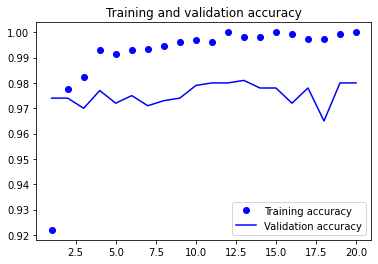

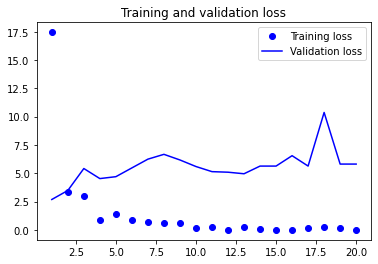

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Feature extraction with data augmentation using a pretrained model

### Test Accuracy - 97.7%

### Validation Accuracy - 98.4%

### Training Accuracy - 98.9%

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 23s 343ms/step - loss: 19.5962 - accuracy: 0.8985 - val_loss: 9.2689 - val_accuracy: 0.9440
Epoch 2/50
63/63 [==============================] - 21s 330ms/step - loss: 7.2744 - accuracy: 0.9425 - val_loss: 10.1028 - val_accuracy: 0.9520
Epoch 3/50
63/63 [==============================] - 21s 334ms/step - loss: 3.3768 - accuracy: 0.9575 - val_loss: 3.4755 - val_accuracy: 0.9810
Epoch 4/50
63/63 [==============================] - 21s 330ms/step - loss: 5.2862 - accuracy: 0.9560 - val_loss: 6.7198 - val_accuracy: 0.9680
Epoch 5/50
63/63 [==============================] - 21s 331ms/step - loss: 4.5670 - accuracy: 0.9675 - val_loss: 5.2929 - val_accuracy: 0.9670
Epoch 6/50
63/63 [==============================] - 21s 332ms/step - loss: 4.0862 - accuracy: 0.9670 - val_loss: 4.3736 - val_accuracy: 0.9800
Epoch 7/50
63/63 [==============================] - 21s 332ms/step - loss: 3.5193 - accuracy: 0.9640 - val_loss: 4.0204 - val_accuracy: 0.97

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 208ms/step - loss: 2.6353 - accuracy: 0.9770
Test accuracy: 0.977


### A pretrained VGG16 model with Fine-tuning 

#### Unfreezing a few of the top layers of a frozen model base used for feature extraction and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers termed fine-tuning. This is referred to as fine-tuning because it modifies the more abstract representations of the model that are being reused to make them more relevant to the task at hand.

### test accuracy - 97.60%

### training accuracy - 99.55%

### validation accuracy - 97.90%


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 25s 365ms/step - loss: 0.4605 - accuracy: 0.9910 - val_loss: 1.8488 - val_accuracy: 0.9810
Epoch 2/30
63/63 [==============================] - 23s 360ms/step - loss: 0.3669 - accuracy: 0.9910 - val_loss: 2.0028 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 23s 359ms/step - loss: 0.4659 - accuracy: 0.9910 - val_loss: 2.0479 - val_accuracy: 0.9820
Epoch 4/30
63/63 [==============================] - 23s 358ms/step - loss: 0.2658 - accuracy: 0.9910 - val_loss: 2.0922 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 23s 359ms/step - loss: 0.4372 - accuracy: 0.9910 - val_loss: 2.3742 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 23s 358ms/step - loss: 0.2483 - accuracy: 0.9930 - val_loss: 2.0797 - val_accuracy: 0.9800
Epoch 7/30
63/63 [==============================] - 23s 363ms/step - loss: 0.2834 - accuracy: 0.9940 - val_loss: 1.8031 - val_accuracy: 0.9780

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 209ms/step - loss: 1.9597 - accuracy: 0.9760
Test accuracy: 0.976


## Summary

### Using a Pre-trained model without Augmentation

#### We reach a validation accuracy of about 99.55% which is better than what we achieved while training the small model from scratch. This won’t always be the case when you use pretrained features.

#### Despite employing a high rate of dropout, the plots also show that we're overfitting nearly from the beginning. This is due to the fact that this method does not employ data augmentation, which is critical for avoiding overfitting with tiny image datasets.
#### The test accuracy of the Pre-trained model with fine tuning is 97.6%.